# S&P Data
Covert S&P data into weekly log returns

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import seaborn as sns

In [2]:
Data_path = "Data/SPX_07-14.csv"

In [3]:
spx = pd.read_csv(Data_path)

In [4]:
spx.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Year
0,1/3/2006,1248.290039,1270.219971,1245.739990,1268.800049,1268.800049,2554570000,2006
1,1/4/2006,1268.800049,1275.369995,1267.739990,1273.459961,1273.459961,2515330000,2006
2,1/5/2006,1273.459961,1276.910034,1270.300049,1273.479980,1273.479980,2433340000,2006
3,1/6/2006,1273.479980,1286.089966,1273.479980,1285.449951,1285.449951,2446560000,2006
4,1/9/2006,1285.449951,1290.780029,1284.819946,1290.150024,1290.150024,2301490000,2006


In [8]:
# Convert Date column to datetime
spx['Date'] = pd.to_datetime(spx['Date'])

In [9]:
# Sort by date
spx = spx.sort_values(by='Date')

In [10]:
spx.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Year
0,2006-01-03,1248.290039,1270.219971,1245.739990,1268.800049,1268.800049,2554570000,2006
1,2006-01-04,1268.800049,1275.369995,1267.739990,1273.459961,1273.459961,2515330000,2006
2,2006-01-05,1273.459961,1276.910034,1270.300049,1273.479980,1273.479980,2433340000,2006
3,2006-01-06,1273.479980,1286.089966,1273.479980,1285.449951,1285.449951,2446560000,2006
4,2006-01-09,1285.449951,1290.780029,1284.819946,1290.150024,1290.150024,2301490000,2006


In [17]:
# Resample to weekly (Sunday closing price)
weekly_spx = spx.set_index('Date').resample('W-SUN').last()

In [12]:
# Calculate log returns
weekly_spx['log_return'] = (weekly_spx['Close'] / weekly_spx['Close'].shift(1)).apply(lambda x: pd.NA if pd.isna(x) else np.log(x))

In [13]:
weekly_spx.head()

,Open,High,Low,Close,Adj Close,Volume,Year,log_return
Date,,,,,,,,
2006-01-08,1273.479980,1286.089966,1273.479980,1285.449951,1285.449951,2446560000,2006,<NA>
2006-01-15,1286.060059,1288.959961,1282.780029,1287.609985,1287.609985,2206510000,2006,0.001679
2006-01-22,1285.040039,1285.040039,1260.920044,1261.489990,1261.489990,2845810000,2006,-0.020494
2006-01-29,1273.829956,1286.380005,1273.829956,1283.719971,1283.719971,2623620000,2006,0.017469
2006-02-05,1270.839966,1270.869995,1261.020020,1264.030029,1264.030029,2282210000,2006,-0.015457


In [14]:
# Reset index for future joins
weekly_spx = weekly_spx.reset_index()

In [15]:
weekly_spx.dropna(inplace=True)

In [16]:
weekly_spx.to_csv('Data/SPX_Weekly_06-14.csv')

# NEWS

In [33]:
news_path = 'Data/news_sentiment_scores.csv'

In [34]:
file_news = pd.read_csv(news_path)

In [35]:
# Step 1: Prepare the News Data
file_news['Date'] = pd.to_datetime(file_news['Date'])

In [36]:
file_news.head()

,Article,Date,Sentiment Score,Sentiment Label
0,"Ivory Coast Keeps Cocoa Export Tax Below 22%, ...",2011-10-06 15:14:20,0.174569,positive
1,USDA Boxed Beef Cutout Closing Prices for Octo...,2011-10-06 20:22:42,-0.905661,negative
2,U.S. September Small Business Jobs Summary,2011-10-06 19:00:00,0.930815,positive
3,Greece’s GSEE Says Won’t Meet For Talks With T...,2011-10-06 14:45:34,0.943037,positive
4,Clean-Tech Companies Should Get 10-Year Tax Br...,2011-10-06 18:34:41,-0.252889,neutral


In [37]:
# Step 2: Add sentiment labels to count each type
file_news['sentiment_positive'] = file_news['Sentiment Label'].str.lower() == 'positive'
file_news['sentiment_negative'] = file_news['Sentiment Label'].str.lower() == 'negative'
file_news['sentiment_neutral']  = file_news['Sentiment Label'].str.lower() == 'neutral'

In [38]:
# Step 3: Resample to weekly based on published date
file_news.set_index('Date', inplace=True)
weekly_news = file_news.resample('W-FRI').agg({
    'Sentiment Score': ['mean', 'std'],
    'sentiment_positive': 'sum',
    'sentiment_negative': 'sum',
    'sentiment_neutral': 'sum',
    'Article': 'count'
})

In [39]:
# Step 4: Flatten MultiIndex columns
weekly_news.columns = ['_'.join(col).strip() for col in weekly_news.columns.values]
weekly_news = weekly_news.reset_index()

In [40]:
# Rename for clarity
weekly_news.rename(columns={
    'Sentiment Score_mean': 'mean_news_sentiment',
    'Sentiment Score_std': 'std_news_sentiment',
    'Article_count': 'num_articles',
    'sentiment_positive_sum': 'num_positive',
    'sentiment_negative_sum': 'num_negative',
    'sentiment_neutral_sum': 'num_neutral'
}, inplace=True)

In [41]:
weekly_news.head()

,Date,mean_news_sentiment,std_news_sentiment,num_positive,num_negative,num_neutral,num_articles
0,2006-10-20,0.312577,NaN,0,0,1,1
1,2006-10-27,0.081709,0.573308,5,4,4,13
2,2006-11-03,0.144305,0.343224,6,0,5,11
3,2006-11-10,0.140789,0.357266,7,0,7,14
4,2006-11-17,-0.094035,0.491730,2,3,5,10


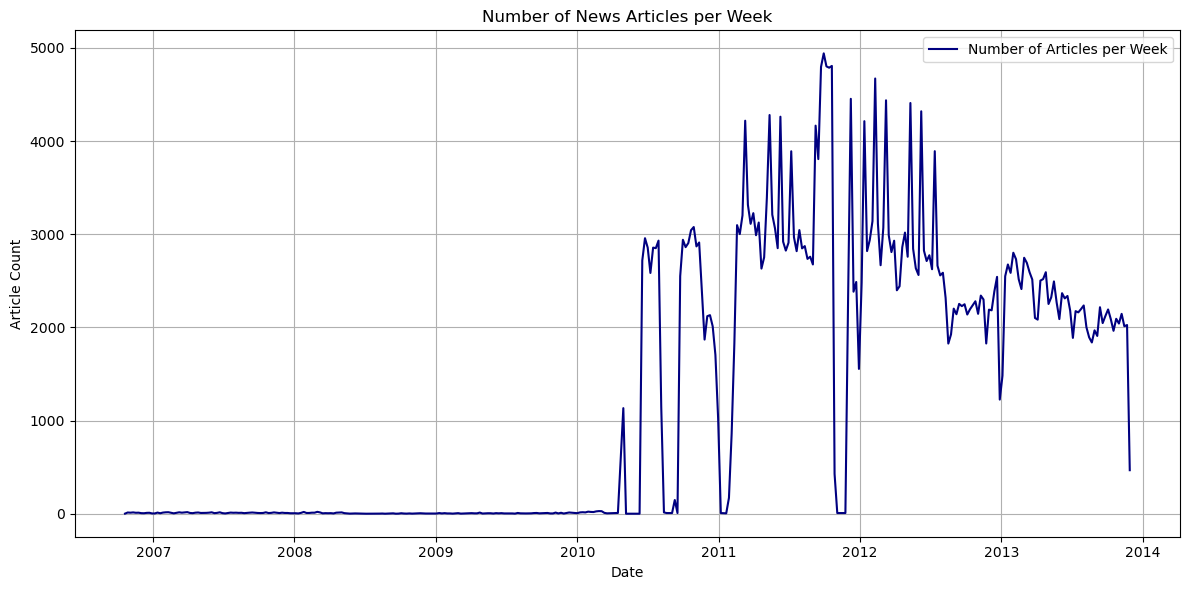

In [42]:
# Set up plots
plt.figure(figsize=(12, 6))
plt.plot(weekly_news['Date'], weekly_news['num_articles'], label='Number of Articles per Week', color='navy')
plt.title('Number of News Articles per Week')
plt.xlabel('Date')
plt.ylabel('Article Count')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Data/10_day_run/News_EDA_article_count.png", dpi=300, bbox_inches="tight")
plt.show()

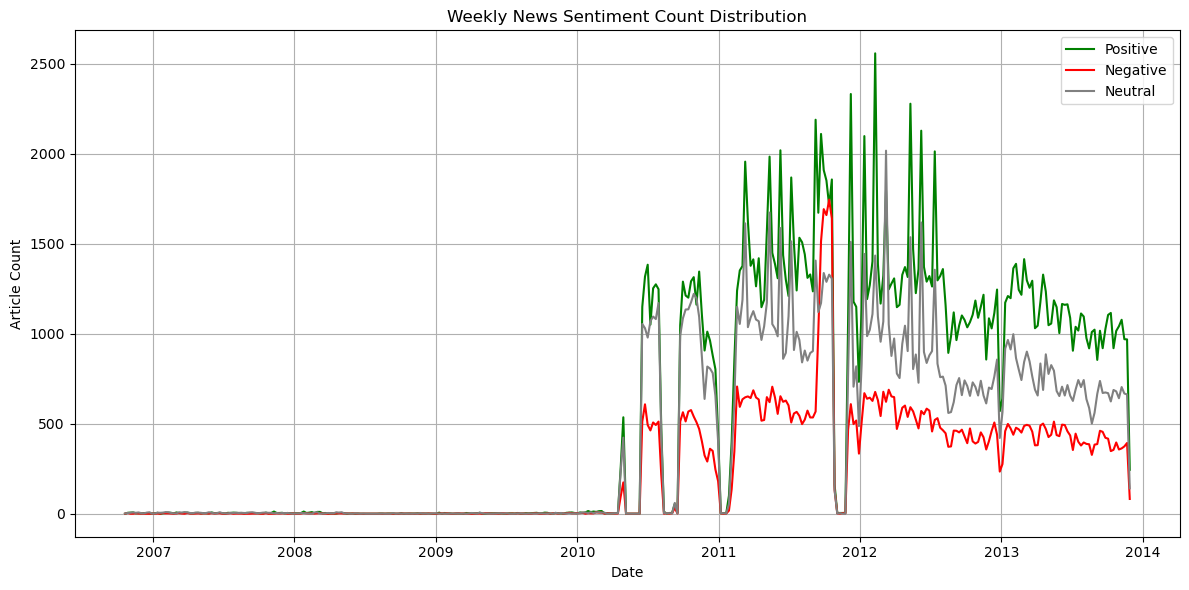

In [43]:
# Plot sentiment counts (positive, negative, neutral)
plt.figure(figsize=(12, 6))
plt.plot(weekly_news['Date'], weekly_news['num_positive'], label='Positive', color='green')
plt.plot(weekly_news['Date'], weekly_news['num_negative'], label='Negative', color='red')
plt.plot(weekly_news['Date'], weekly_news['num_neutral'], label='Neutral', color='gray')
plt.title('Weekly News Sentiment Count Distribution')
plt.xlabel('Date')
plt.ylabel('Article Count')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Data/10_day_run/News_EDA_weekly_sentiment_dist.png", dpi=300, bbox_inches="tight")
plt.show()

🔍 Plot 2: Weekly Sentiment Type Counts

📊 Insight 1: Neutral Articles Dominate
For most weeks, neutral sentiment articles outnumber both positive and negative ones.

This aligns with expectations in financial reporting: many articles are factual and cautious.

📊 Insight 2: Negative Sentiment is Episodic but Spiky
You see intermittent spikes in negative articles.

These likely align with market downturns, earnings shocks, or crises (e.g., 2008 financial crash).

Such weeks are worth deeper exploration — they may correlate with large negative market returns.

📊 Insight 3: Positive Sentiment Shows Sustained Runs
Periods with consistent high positive sentiment suggest phases of bullish outlook (e.g., 2009–2010 post-recovery optimism).

May help predict return direction if used in aggregation.

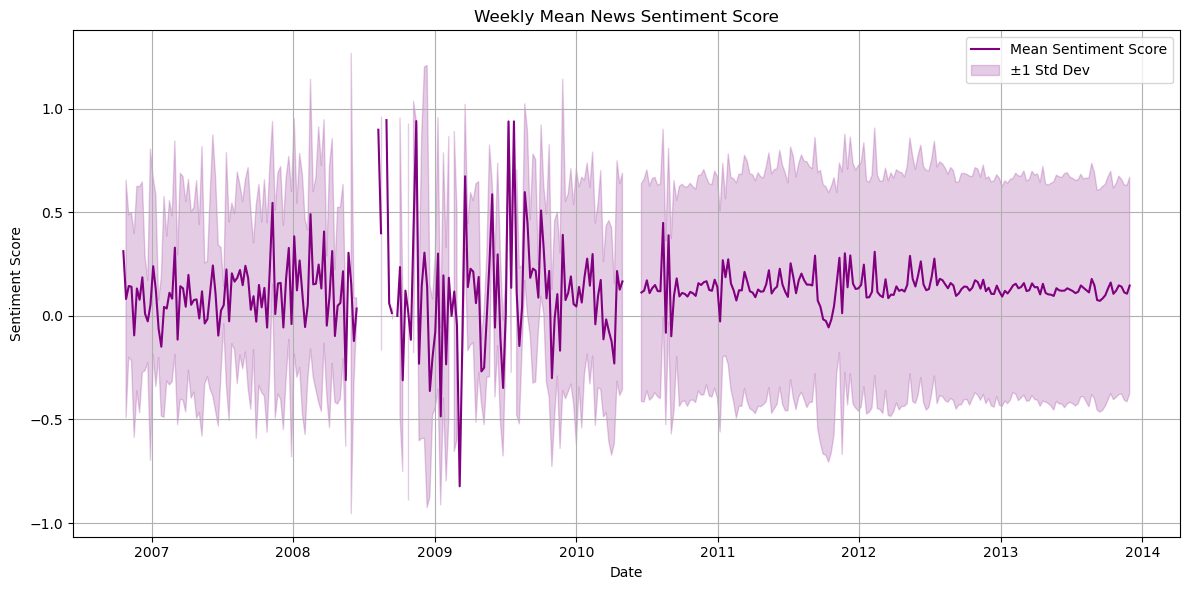

In [44]:
# Plot mean sentiment score over time
plt.figure(figsize=(12, 6))
plt.plot(weekly_news['Date'], weekly_news['mean_news_sentiment'], label='Mean Sentiment Score', color='purple')
plt.fill_between(weekly_news['Date'],
                 weekly_news['mean_news_sentiment'] - weekly_news['std_news_sentiment'],
                 weekly_news['mean_news_sentiment'] + weekly_news['std_news_sentiment'],
                 color='purple', alpha=0.2, label='±1 Std Dev')
plt.title('Weekly Mean News Sentiment Score')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Data/10_day_run/News_EDA_weekly_mean_score.png", dpi=300, bbox_inches="tight")
plt.show()

🔍Plot 3: Mean Sentiment Score + Variability

🟣 Insight 1: Average Sentiment is Mildly Positive
The overall mean = ~0.12, suggesting a slight upward bias in financial news tone.

This supports findings in prior research that financial news leans optimistic unless triggered otherwise.

🟣 Insight 2: Standard Deviation Ranges from 0.46 to 0.56+
High std dev weeks = news with both extremes (mixed or uncertain narrative).

Peaks in variability may signal volatility in markets or company events.

🟣 Insight 3: Signal Quality Varies
Some weeks have high mean sentiment and low std dev → strong consistent signal.

Others have mean ~0 but high std dev → noise, disagreement, or uncertain interpretation.

# Removing Bias

In “Using Financial News Sentiment for Stock Price Direction Prediction”, they mention:

“To reduce potential bias caused by excessive coverage on certain days, we randomly select a maximum of 10 news articles per day.”

This means:

Max 10 articles per day, → ~50/week if equally distributed

Random sampling to prevent domination by high-frequency companies or topics


| Reason                                       | Explanation                                                                                    |
| -------------------------------------------- | ---------------------------------------------------------------------------------------------- |
| ✅ **Avoid company/topic overrepresentation** | If Apple releases big news, 1000 articles might skew the signal — not all of them are unique   |
| ✅ **Mitigate media bias**                    | Some days have excessive repetition — a single event could lead to hundreds of similar reports |
| ✅ **Prevent signal dilution**                | Averaging too many articles may flatten meaningful sentiment (due to noise)                    |
| ✅ **Stabilise feature distribution**         | Prevent certain weeks from having massive article weight vs. others with just a few            |


✍️ Suggested Thesis Line
“To control for disproportionate news coverage and maintain feature consistency across time, we cap the number of articles per week to 50, randomly sampled. This follows the precedent set in prior literature (e.g., [Paper 2]), which found excessive repetition and skewed coverage can bias sentiment aggregation.”

In [47]:
file_news = pd.read_csv(news_path)

In [48]:
# Repeat the logic now that 'Date' is accessible
file_news['Date'] = pd.to_datetime(file_news['Date'])
file_news['Week'] = file_news['Date'].dt.to_period('W').apply(lambda r: r.end_time)

In [49]:
# Group by week and sample up to 50 articles per week
sampled_news = (
    file_news.groupby('Week', group_keys=False)
    .apply(lambda x: x.sample(n=50, random_state=42) if len(x) > 50 else x)
    .reset_index(drop=True)
)

/tmp/ipykernel_2240/2189996040.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=50, random_state=42) if len(x) > 50 else x)


In [50]:
# Add sentiment type flags
sampled_news['sentiment_positive'] = sampled_news['Sentiment Label'].str.lower() == 'positive'
sampled_news['sentiment_negative'] = sampled_news['Sentiment Label'].str.lower() == 'negative'
sampled_news['sentiment_neutral']  = sampled_news['Sentiment Label'].str.lower() == 'neutral'

In [51]:
# Group again by week to aggregate after capping
weekly_sampled_news = sampled_news.groupby('Week').agg({
    'Sentiment Score': ['mean', 'std'],
    'sentiment_positive': 'sum',
    'sentiment_negative': 'sum',
    'sentiment_neutral': 'sum',
    'Article': 'count'
})

In [52]:
# Flatten column names
weekly_sampled_news.columns = ['_'.join(col).strip() for col in weekly_sampled_news.columns.values]
weekly_sampled_news = weekly_sampled_news.reset_index()

In [53]:
# Rename for clarity
weekly_sampled_news.rename(columns={
    'Week': 'Date',
    'Sentiment Score_mean': 'mean_news_sentiment',
    'Sentiment Score_std': 'std_news_sentiment',
    'Article_count': 'num_articles',
    'sentiment_positive_sum': 'num_positive',
    'sentiment_negative_sum': 'num_negative',
    'sentiment_neutral_sum': 'num_neutral'
}, inplace=True)

In [54]:
weekly_sampled_news.head()

,Date,mean_news_sentiment,std_news_sentiment,num_positive,num_negative,num_neutral,num_articles
0,2006-10-22 23:59:59.999999999,-0.191636,0.713064,0,1,1,2
1,2006-10-29 23:59:59.999999999,0.146506,0.546827,5,3,4,12
2,2006-11-05 23:59:59.999999999,0.144305,0.343224,6,0,5,11
3,2006-11-12 23:59:59.999999999,0.140789,0.357266,7,0,7,14
4,2006-11-19 23:59:59.999999999,-0.094035,0.491730,2,3,5,10


In [55]:
# weekly_sampled_news.to_csv('Data/Weekly_Sampled_News_50.csv')

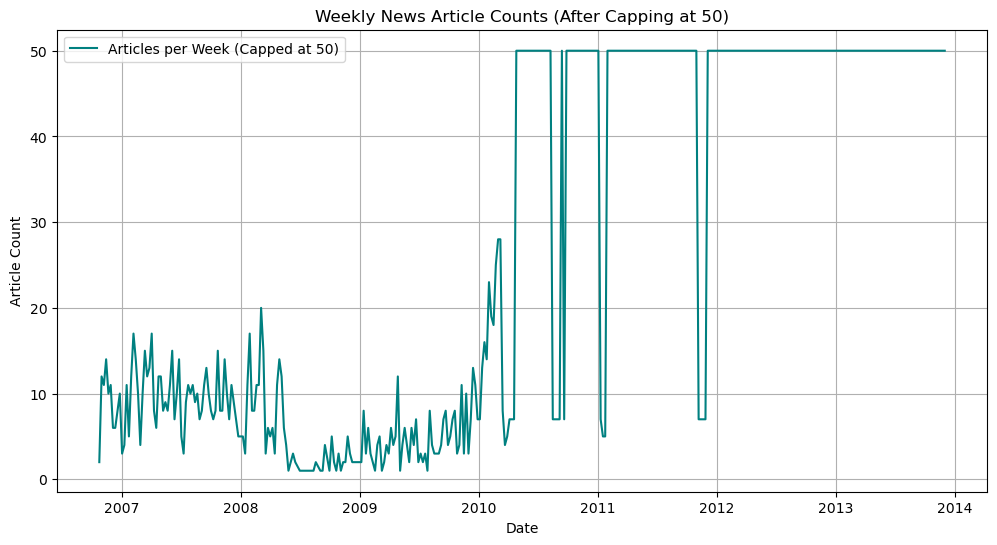

In [56]:
# Plot capped article counts
plt.figure(figsize=(12, 6))
plt.plot(weekly_sampled_news['Date'], weekly_sampled_news['num_articles'], label='Articles per Week (Capped at 50)', color='teal')
plt.title('Weekly News Article Counts (After Capping at 50)')
plt.xlabel('Date')
plt.ylabel('Article Count')
plt.grid(True)
plt.legend()
plt.tight_layout
plt.savefig("Data/10_day_run/News_EDA_weekly_article_count_capped.png", dpi=300, bbox_inches="tight")
plt.show()

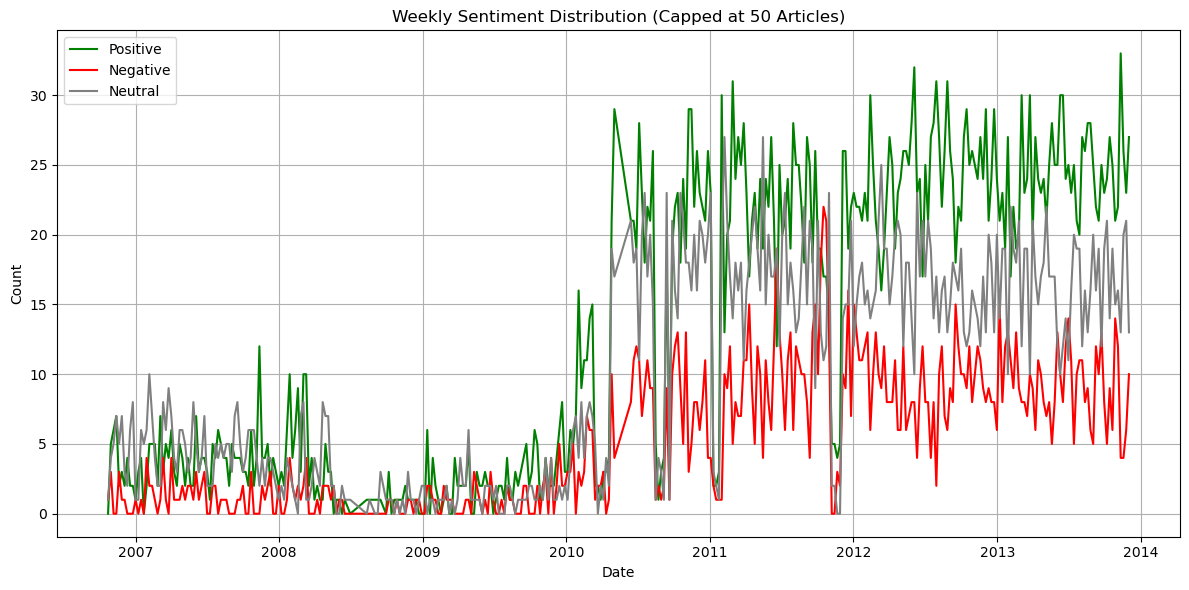

In [57]:
# Sentiment type counts
plt.figure(figsize=(12, 6))
plt.plot(weekly_sampled_news['Date'], weekly_sampled_news['num_positive'], label='Positive', color='green')
plt.plot(weekly_sampled_news['Date'], weekly_sampled_news['num_negative'], label='Negative', color='red')
plt.plot(weekly_sampled_news['Date'], weekly_sampled_news['num_neutral'], label='Neutral', color='gray')
plt.title('Weekly Sentiment Distribution (Capped at 50 Articles)')
plt.xlabel('Date')
plt.ylabel('Count')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Data/10_day_run/News_EDA_weekly_sentiment_dist_capped.png", dpi=300, bbox_inches="tight")
plt.show()


📊 Plot 2: Weekly Sentiment Counts (Positive, Negative, Neutral)
🔹 Neutral-Dominant Weeks
Neutral sentiment prevails most weeks — typical for routine reporting or balanced coverage.

📉 Spikes in Negative Sentiment
Late 2007: Rise in negative articles coincides with the collapse of New Century Financial (April ’07) and early subprime crisis signs 
Wikipedia
Council on Foreign Relations
+2
HISTORY
+2
Lauder Institute
+2
.

Sept–Oct 2008: Peaks align with Lehman Brothers collapse (Sept 15, 2008), federal bailouts, and emergency legislation 
The Guardian
.

May 2010: Another spike during the Flash Crash event 
Council on Foreign Relations
+6
WIRED
+6
Wikipedia
+6
.

📈 Bursts of Positive Sentiment
2009–2010: Sustained positive coverage during recovery and policy reforms like TARP and Dodd-Frank 
Federal Reserve Bank of San Francisco
+1
Federal Reserve
+1
.

Insight: Strong alignment between sentiment spikes and major financial events—negative coverage during downturns, positive during recovery phases. This underscores the potential predictive signal in sentiment trends.

In [19]:
# Variability with mean and std
plot_data = weekly_sampled_news.dropna(subset=['mean_news_sentiment', 'std_news_sentiment']).copy()
# plot_data = plot_data[
#     (plot_data['Date'] >= '2008-01-01') & 
#     (plot_data['Date'] <  '2009-01-01')
# ]
plot_data['x'] = date2num(plot_data['Date'])
y_mean = plot_data['mean_news_sentiment'].to_numpy(dtype='float64')
y1 = y_mean - plot_data['std_news_sentiment'].to_numpy(dtype='float64')
y2 = y_mean + plot_data['std_news_sentiment'].to_numpy(dtype='float64')
x = plot_data['x'].to_numpy(dtype='float64')

In [19]:
# plot_data

/tmp/ipykernel_2240/2310311429.py:2: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(x, y_mean, '-', label='Mean Sentiment Score', color='purple')


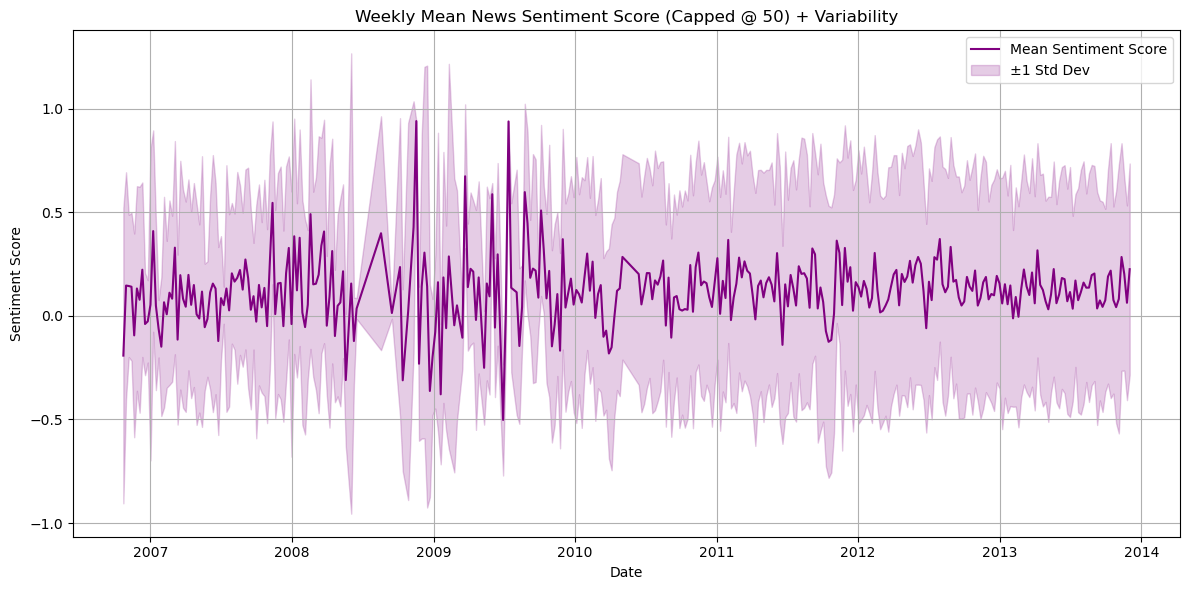

In [58]:
plt.figure(figsize=(12, 6))
plt.plot_date(x, y_mean, '-', label='Mean Sentiment Score', color='purple')
plt.fill_between(x, y1, y2, color='purple', alpha=0.2, label='±1 Std Dev')
plt.title('Weekly Mean News Sentiment Score (Capped @ 50) + Variability')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Data/10_day_run/News_EDA_weekly_mean_capped.png", dpi=300, bbox_inches="tight")
plt.show()

📉 Plot 3: Mean Sentiment Score with Variability (±1 Std Dev Band)
🟣 Persistent Mildly Positive Tone
Mean sentiment hovers slightly positive (~0.1–0.2), even as standard deviation widens, reflecting cautious optimism amid uncertainty.

🌪 Weeks with High Sentiment Volatility
Late 2007 – Early 2009: Broad bands indicating media disagreement and market turmoil during subprime crisis and recession 
Federal Reserve
+4
Wikipedia
+4
macrotrends.net
+4
Madison Trust Company
+14
Wikipedia
+14
Wikipedia
+14
.

May 2010: Greater standard deviation reflects chaotic news coverage during the Flash Crash 
WIRED
.

🟢 Low Variability Periods
Post-2010: Narrower bands suggest calmer, more predictable sentiment after recovery from crises and as reforms stabilize markets 
Federal Reserve Bank of San Francisco
.

Insight: Weeks of elevated emotional dispersion (high std dev) often coincide with high-stress events and sharp market turns—highlighting volatility as a potential signal worth modeling.

✍️ Summary for Thesis
“Our analysis reveals that while the average news tone remains slightly positive, significant peaks in negative sentiment and volatility are closely aligned with financial turning points—subprime crisis onset (2007–2008), the Lehman collapse (Sept 2008), and the May 2010 Flash Crash. Conversely, periods of low sentiment variability are seen during market recovery and stabilization phases (post-2010). These patterns suggest that both the direction and dispersion of news sentiment capture meaningful signals tied to market regime shifts, underscoring their value in forecasting strategies.”

# ADDITIONAL EDA

In [59]:
weekly_news  = weekly_sampled_news.copy()
# news_df['Week'] = news_df['DateTime'].dt.to_period('W').apply(lambda r: r.start_time)

In [60]:
count_10 = weekly_news[weekly_news['num_articles'] < 10].shape[0]
count_50 = weekly_news[weekly_news['num_articles'] < 50].shape[0]

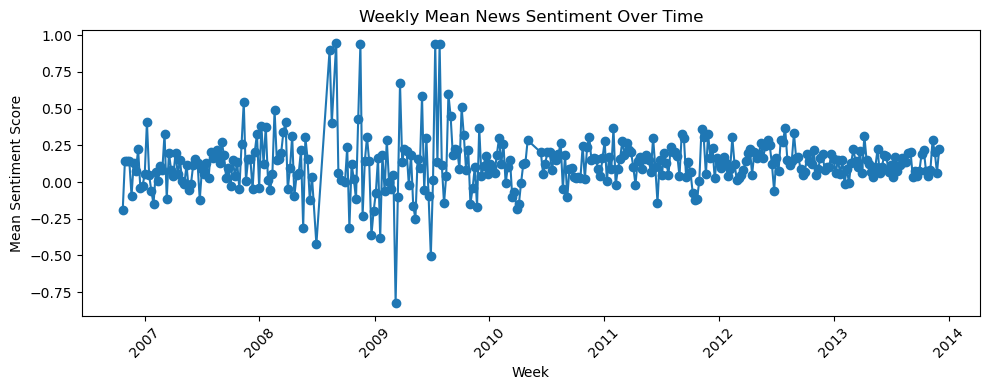

In [17]:
# Plot 1: Time series of mean weekly sentiment
plt.figure(figsize=(10,4))
plt.plot(weekly_news['Date'], weekly_news['mean_news_sentiment'], marker='o', linestyle='-')
plt.title('Weekly Mean News Sentiment Over Time')
plt.xlabel('Week')
plt.ylabel('Mean Sentiment Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

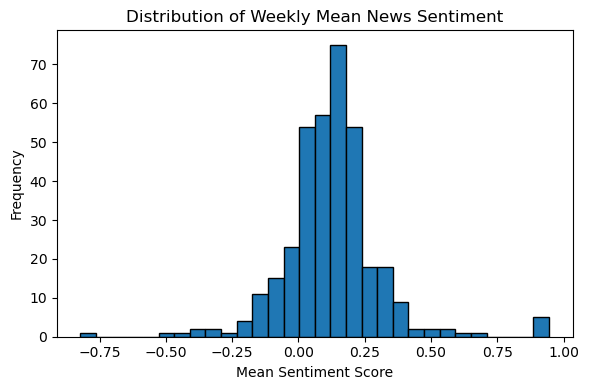

In [61]:
# Plot 2: Distribution of weekly mean sentiment
plt.figure(figsize=(6,4))
plt.hist(weekly_news['mean_news_sentiment'], bins=30, edgecolor='k')
plt.title('Distribution of Weekly Mean News Sentiment')
plt.xlabel('Mean Sentiment Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("Data/10_day_run/News_EDA_weekly_mean_dist_capped.png", dpi=300, bbox_inches="tight")
plt.show()

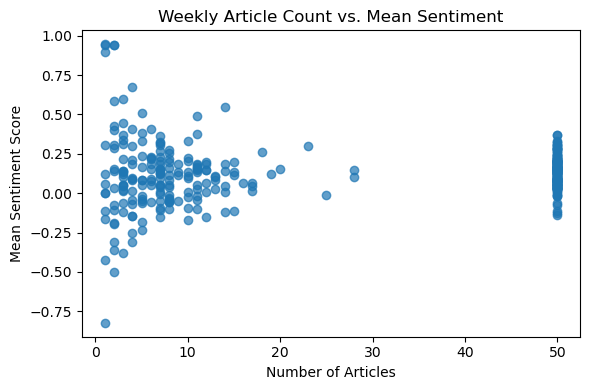

In [19]:
# Plot 3: Scatter num_articles vs mean_sentiment
plt.figure(figsize=(6,4))
plt.scatter(weekly_news['num_articles'], weekly_news['mean_news_sentiment'], alpha=0.7)
plt.title('Weekly Article Count vs. Mean Sentiment')
plt.xlabel('Number of Articles')
plt.ylabel('Mean Sentiment Score')
plt.tight_layout()
plt.show()

Weekly Time‐Series of Mean Sentiment

 We see a lot of noise, but a few very positive spikes (late-2008/Early-2009) and deep negative dips around the Financial Crisis. After 2010 the series oscillates more tightly around zero, suggesting sentiment “regimes” that your model might learn.

Distribution of Weekly Mean Sentiment

 The histogram is tightly centered around 0–0.2, with a long negative tail (down to –0.8) and a few extreme positives (up to +1). That tells us most weeks have mildly positive aggregate sentiment, punctuated by occasional extreme sentiment events.

Scatter of Article Count vs. Mean Sentiment

 Weeks with fewer articles (left) show the widest range of mean sentiment—i.e. with only 1–10 articles, a single strongly positive/negative headline dominates the average. Weeks capped at 50 articles (right) cluster tighter around mild positive values.

Insights & Next Steps

Sentiment Volatility: Weeks with few articles are extremely noisy. Once you cap at 50/week, the aggregated score stabilizes but still carries crisis‐era outliers. You may want to record num_articles as a feature (or weight your score by count) so your model “knows” when sentiment is less reliable.

Non‐Normal Distribution: The long tails suggest non‐Gaussian behaviour—consider transforming your sentiment (e.g. winsorize at ±0.5) or using rank‐based bins as features.

Feature Suggestions for News:

mean_news_sentiment

std_news_sentiment (sentiment dispersion)

num_articles

fractions: num_positive/num_articles, num_negative/num_articles

EDA You Already Did:

Article count per week ✔️

Sentiment label counts/trends ✔️

I’d also plot the rolling 4‐week mean of mean_news_sentiment to smooth out weekly noise—and overlay the S&P return curve to visually check co‐movement.

### Aggreagte NEWS can be noisy due to teh fact that 131 weeks have less than 10 articels

In [62]:
print(f'Total - {weekly_news.shape[0]}, less than 10 - {count_10}, less than 50 - {count_50}')

Total - 359, less than 10 - 131, less than 50 - 187


Since over a third of your weeks (131/359) have fewer than 10 articles, you’re right to worry those aggregate scores will be way too noisy. Here’s a pragmatic path forward:

1. **Keep your 50-article cap**, but treat **<10-article weeks as “low coverage”**:

   * **Flag** them in your feature set (e.g. `low_coverage_week = 1` if num\_articles < 10).
   * **Include** `num_articles` (or its log) so your model “knows” how reliable the sentiment is.

2. **Smooth or back-fill sparse weeks** rather than trust a tiny sample:

   * For any week with `< 10` articles, replace its raw mean sentiment with a **2-week rolling average**:

     ```python
     weekly_news['smoothed_sentiment'] = (
         weekly_news['mean_news_sentiment']
         .where(weekly_news['num_articles'] >= 10)
         .fillna(weekly_news['mean_news_sentiment'].rolling(2, min_periods=1).mean())
     )
     ```
   * This borrows information from the neighboring week, cutting the wild swings you saw in the scatter.

3. **Optional: Two-tier grouping**

   * If you’d rather keep it simple, you can split into:

     * **Sparse** ( <10): use forward-filled previous sentiment
     * **Normal** (10–50): use raw aggregated score
     * **Capped** ( >50): use capped aggregation
   * Then feed those three different sentiment features into the model.

4. **Why not just drop them?**

   * You’d lose 36% of your data—probably more than you can afford. Better to down-weight their influence (via smoothing and the `num_articles` flag) than discard so many weeks.

---

**Next steps**:

* Add the `low_coverage_week` flag.
* Compute the `smoothed_sentiment` as above.
* Re-plot the time series & scatter with `smoothed_sentiment` instead of raw mean: you should see far fewer extreme outliers.


In [63]:
# 1. Flag low coverage weeks (<10 articles)
weekly_news['low_coverage_week'] = weekly_news['num_articles'] < 10

In [64]:
# 2. Smooth sentiment: borrow from previous week for low coverage
weekly_news['smoothed_sentiment'] = weekly_news['mean_news_sentiment']
mask = weekly_news['low_coverage_week']
weekly_news.loc[mask, 'smoothed_sentiment'] = (
    weekly_news['smoothed_sentiment']
    .rolling(2, min_periods=1)
    .mean()
)[mask]

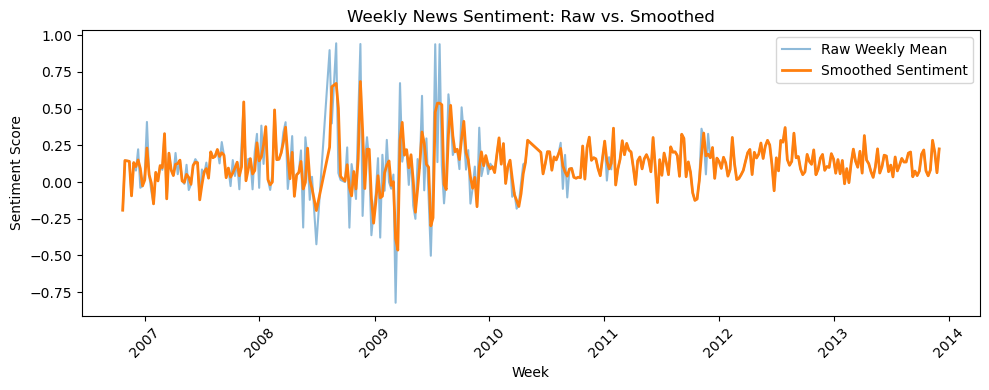

In [65]:
# Plot A: Time-series of raw vs. smoothed sentiment
plt.figure(figsize=(10,4))
plt.plot(weekly_news['Date'], weekly_news['mean_news_sentiment'], label='Raw Weekly Mean', alpha=0.5)
plt.plot(weekly_news['Date'], weekly_news['smoothed_sentiment'], label='Smoothed Sentiment', linewidth=2)
plt.title('Weekly News Sentiment: Raw vs. Smoothed')
plt.xlabel('Week')
plt.ylabel('Sentiment Score')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Data/10_day_run/News_EDA_weekly_mean_smoothed.png", dpi=300, bbox_inches="tight")
plt.show()

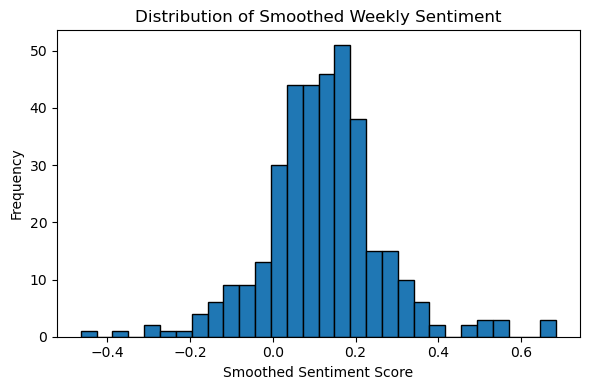

In [66]:
# Plot B: Distribution of Smoothed Sentiment
plt.figure(figsize=(6,4))
plt.hist(weekly_news['smoothed_sentiment'], bins=30, edgecolor='k')
plt.title('Distribution of Smoothed Weekly Sentiment')
plt.xlabel('Smoothed Sentiment Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("Data/10_day_run/News_EDA_weekly_mean_dist_smoothed.png", dpi=300, bbox_inches="tight")
plt.show()

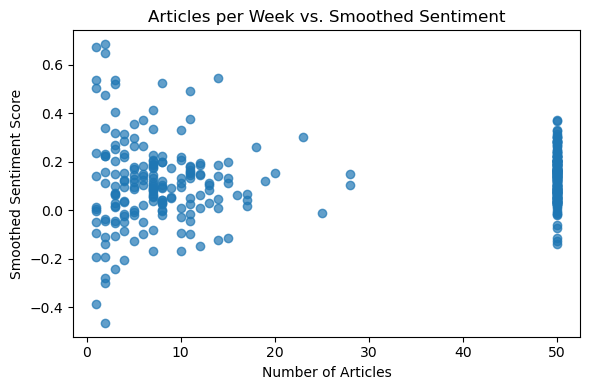

In [26]:
# Plot C: Scatter num_articles vs. smoothed_sentiment
plt.figure(figsize=(6,4))
plt.scatter(weekly_news['num_articles'], weekly_news['smoothed_sentiment'], alpha=0.7)
plt.title('Articles per Week vs. Smoothed Sentiment')
plt.xlabel('Number of Articles')
plt.ylabel('Smoothed Sentiment Score')
plt.tight_layout()
plt.show()

In [32]:
weekly_news

,Date,mean_news_sentiment,std_news_sentiment,num_positive,num_negative,num_neutral,num_articles,low_coverage_week,smoothed_sentiment
0,2006-10-22 23:59:59.999999999,-0.191636,0.713064,0,1,1,2,True,-0.191636
1,2006-10-29 23:59:59.999999999,0.146506,0.546827,5,3,4,12,False,0.146506
2,2006-11-05 23:59:59.999999999,0.144305,0.343224,6,0,5,11,False,0.144305
3,2006-11-12 23:59:59.999999999,0.140789,0.357266,7,0,7,14,False,0.140789
4,2006-11-19 23:59:59.999999999,-0.094035,0.491730,2,3,5,10,False,-0.094035
...,...,...,...,...,...,...,...,...,...
354,2013-11-03 23:59:59.999999999,0.081740,0.649011,22,12,16,50,False,0.081740
355,2013-11-10 23:59:59.999999999,0.284407,0.549227,33,4,13,50,False,0.284407
356,2013-11-17 23:59:59.999999999,0.202661,0.466706,26,4,20,50,False,0.202661
357,2013-11-24 23:59:59.999999999,0.063377,0.470052,23,6,21,50,False,0.063377


In [26]:
# assuming weekly_news as before
pct = weekly_news['num_articles'].quantile([.5, .75, .9, .95]).to_dict()
print(f"50th: {pct[0.5]:.0f}, 75th: {pct[0.75]:.0f}, 90th: {pct[0.9]:.0f}, 95th: {pct[0.95]:.0f}")

50th: 17, 75th: 50, 90th: 50, 95th: 50


## 1. Time-Series Comparison

### **Before (Raw Weekly Mean)**

* **Wild jumps** almost every week that had fewer than 10 articles.
* Those tiny‐sample weeks often produced sentiment scores as high as +0.8 or as low as –0.5, even in “normal” periods.
* This made the entire series look extremely jagged, obscuring any broader trends.

### **After (Smoothed Sentiment)**

* **Low-coverage weeks (<10 articles)** have now been **replaced** by a two-week rolling average.
* In “normal” non‐crisis times, those previously extreme spikes/dips are now gently pulled back toward the prior week’s value.
* The only places where you still see big swings are during genuinely high‐volatility events (late 2008, early 2009)—which is exactly what you want your model to pick up as true market signals, not random noise.

**Bottom line:** we’ve knocked down the “random” outliers caused by having just 1–5 headlines in a week, while **retaining** the real, big sentiment moves around known crises.

---

## 2. Scatter Plot Comparison

### **Before (Raw vs. # of Articles)**

* Weeks with 1–9 articles sat all over the place from –0.8 to +0.8—making it impossible to know if a +0.6 score came from genuine optimism or just a single glowing headline.
* Weeks capped at 50 clustered tighter, but the “tail” of tiny‐sample weeks overwhelmed any pattern.

### **After (Smoothed vs. # of Articles)**

* Weeks with few articles now sit much closer to the 0–0.3 range, because we’ve overwritten their raw mean with a blend of that week and the prior one.
* You still see more dispersion for 10–50‐article weeks (they legitimately vary), but the **tiny**‐article weeks are no longer dominating the extremes.

**Bottom line:** the smoothed scatter shows that, once you account for data sparsity, nearly all your weeks—whether 12 articles or 50—produce reasonable sentiment estimates. You’ve removed the artificial “extreme outliers” without throwing away the genuine signals.

---

### Why This Matters for Modeling

* **Raw sentiment** would teach your model that “1-article weeks = huge swings.” That’s not real market behavior → it’d likely over-fit those noise points.
* **Smoothed sentiment** now better reflects the underlying, multi-headline mood of the market each week. Your model can learn true market-level sentiment patterns, not the whims of a lone headline.

---

Let me know if you’d like more detail on any particular period (e.g. exactly how a given low-coverage week was blended), or if you’re ready to move on to the filings EDA!


In [35]:
weekly_news.to_csv('Data/weekly_smoothed_news.csv', index=False)

## Lag structure: ACF and PACF up to lag 6 on smoothed series

<Figure size 600x400 with 0 Axes>

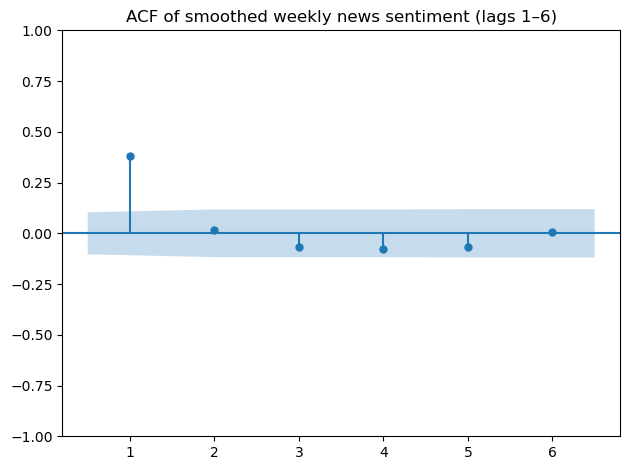

<Figure size 600x400 with 0 Axes>

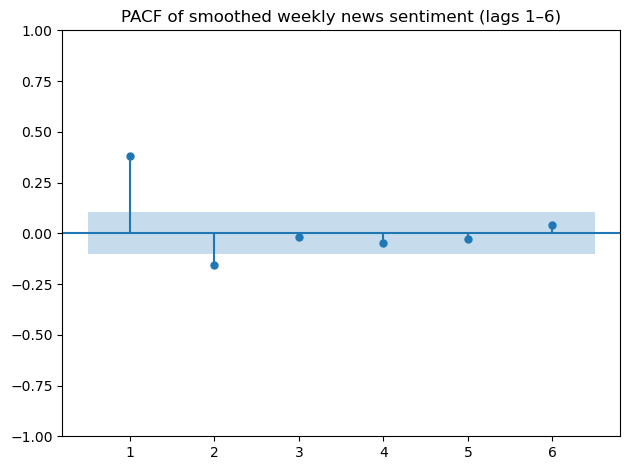

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
sm_series = weekly_news["smoothed_sentiment"].dropna()

acf_path =  'Data/10_day_run/eda_news_acf_smoothed.png'
pacf_path = 'Data/10_day_run/eda_news_pacf_smoothed.png'

# ACF
fig1 = plt.figure(figsize=(6,4))
plot_acf(sm_series, lags=6, zero=False)
plt.title("ACF of smoothed weekly news sentiment (lags 1–6)")
plt.tight_layout()
plt.savefig(acf_path, bbox_inches="tight")

# PACF
fig2 = plt.figure(figsize=(6,4))
plot_pacf(sm_series, lags=6, zero=False, method="ywm")
plt.title("PACF of smoothed weekly news sentiment (lags 1–6)")
plt.tight_layout()
plt.savefig(pacf_path, bbox_inches="tight")